In [7]:
# =======================================================
# Cell 1: Imports
# =======================================================
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# =======================================================
# Cell 2: Configuration
# =======================================================
# 你已经微调好的、保存在本地的 FP32 BERT-SST2 模型的路径
MODEL_PATH = "./my_bert_sst2_finetuned/checkpoint-1800" 
# 用来加载分词器的基础模型名称，应与你微调时使用的一致
TOKENIZER_NAME = "bert-base-uncased" 
# -------------------------

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Configuration:")
print(f"  Model Path: {MODEL_PATH}")
print(f"  Tokenizer: {TOKENIZER_NAME}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Using Device: {DEVICE}")

Configuration:
  Model Path: ./my_bert_sst2_finetuned/checkpoint-1800
  Tokenizer: bert-base-uncased
  Batch Size: 32
  Using Device: cuda


In [3]:
# =======================================================
# Cell 3: Helper Functions (Corrected)
# =======================================================

def load_fp32_model_and_tokenizer(model_path, tokenizer_name, device):
    """
    加载 FP32 模型和分词器。
    这个函数专门用于加载标准的、未经量化的 Hugging Face 模型。
    """
    print(f"Loading tokenizer from '{tokenizer_name}'...")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    print(f"Loading FP32 model from '{model_path}'...")
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    model.eval() # 设置为评估模式
    
    print("Model and tokenizer loaded.")
    return model, tokenizer

def evaluate_accuracy(model, dataloader, device):
    """
    在给定的数据集上评估模型的准确率。
    """
    total_correct = 0
    total_samples = 0
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Accuracy"):
            # 将数据移动到模型所在的设备
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # 模型推理
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            
            # 获取预测结果
            predictions = torch.argmax(outputs.logits, dim=-1)
            
            # ######################################
            #  修正处：将 batch["labels"] 修改为 batch["label"]
            # ######################################
            labels = batch["label"] 
            
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)
            
    return total_correct / total_samples

print("Helper functions defined: load_fp32_model_and_tokenizer, evaluate_accuracy")

Helper functions defined: load_fp32_model_and_tokenizer, evaluate_accuracy


In [4]:
# =======================================================
# Cell 4: Data Preparation
# =======================================================
print("Preparing dataset...")
# 1. 加载原始数据集
raw_datasets = load_dataset("glue", "sst2")
eval_dataset = raw_datasets["validation"]

# 2. 定义分词函数
# 注意：这里我们使用一个临时的分词器实例，以避免和主分词器混淆
tokenizer_for_map = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
def tokenize_function(examples):
    return tokenizer_for_map(examples["sentence"], padding="max_length", truncation=True, max_length=128)

# 3. 对数据集进行分词和格式化
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = tokenized_eval_dataset.remove_columns(["sentence", "idx"])
tokenized_eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 4. 创建 DataLoader
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=BATCH_SIZE)

print("Dataset prepared and DataLoader created.")

Preparing dataset...
Dataset prepared and DataLoader created.


In [5]:
# =======================================================
# Cell 5: Main Ablation Study Workflow
# =======================================================

# --- 5.1 加载 Baseline 模型 ---
model, tokenizer = load_fp32_model_and_tokenizer(MODEL_PATH, TOKENIZER_NAME, DEVICE)

# --- 5.2 计算 Baseline 准确率 ---
print("\nCalculating baseline accuracy...")
baseline_accuracy = evaluate_accuracy(model, eval_dataloader, DEVICE)
print(f"\nBaseline Model Accuracy: {baseline_accuracy:.4f}")

# --- 5.3 执行逐层消融实验 ---
sensitivity_scores = {}
num_layers = model.config.num_hidden_layers

# 定义一个空的 forward 函数，用于“屏蔽”层
def identity_forward(hidden_states, *args, **kwargs):
    return (hidden_states,)

print(f"\nStarting ablation study for {num_layers} layers...")
for i in range(num_layers):
    print(f"--- Analyzing Layer {i} ---")
    
    # 保存原始层的 forward 方法
    original_forward = model.bert.encoder.layer[i].forward
    
    # 替换为 identity_forward 来“屏蔽”该层
    model.bert.encoder.layer[i].forward = identity_forward
    
    # 评估修改后模型的性能
    acc_after_ablation = evaluate_accuracy(model, eval_dataloader, DEVICE)
    
    # 计算敏感度（准确率下降值）
    sensitivity = baseline_accuracy - acc_after_ablation
    sensitivity_scores[f"Layer {i}"] = sensitivity
    print(f"Accuracy after removing layer {i}: {acc_after_ablation:.4f}")
    print(f"Sensitivity (Accuracy Drop): {sensitivity:.4f}")
    
    # ！！！恢复原始的 forward 方法，确保下一轮分析的独立性！！！
    model.bert.encoder.layer[i].forward = original_forward

print("\n--- Sensitivity Analysis Complete ---")

Loading tokenizer from 'bert-base-uncased'...
Loading FP32 model from './my_bert_sst2_finetuned/checkpoint-1800'...
Model and tokenizer loaded.

Calculating baseline accuracy...


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


Baseline Model Accuracy: 0.9300

Starting ablation study for 12 layers...
--- Analyzing Layer 0 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 0: 0.9243
Sensitivity (Accuracy Drop): 0.0057
--- Analyzing Layer 1 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 1: 0.9335
Sensitivity (Accuracy Drop): -0.0034
--- Analyzing Layer 2 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 2: 0.9255
Sensitivity (Accuracy Drop): 0.0046
--- Analyzing Layer 3 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 3: 0.9243
Sensitivity (Accuracy Drop): 0.0057
--- Analyzing Layer 4 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 4: 0.9278
Sensitivity (Accuracy Drop): 0.0023
--- Analyzing Layer 5 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 5: 0.9220
Sensitivity (Accuracy Drop): 0.0080
--- Analyzing Layer 6 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 6: 0.9071
Sensitivity (Accuracy Drop): 0.0229
--- Analyzing Layer 7 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 7: 0.9128
Sensitivity (Accuracy Drop): 0.0172
--- Analyzing Layer 8 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 8: 0.8991
Sensitivity (Accuracy Drop): 0.0310
--- Analyzing Layer 9 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 9: 0.9232
Sensitivity (Accuracy Drop): 0.0069
--- Analyzing Layer 10 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 10: 0.9266
Sensitivity (Accuracy Drop): 0.0034
--- Analyzing Layer 11 ---


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

Accuracy after removing layer 11: 0.9289
Sensitivity (Accuracy Drop): 0.0011

--- Sensitivity Analysis Complete ---



--- Layer Sensitivity Ranking (from least to most important) ---
Layer 1: -0.0034
Layer 11: 0.0011
Layer 4: 0.0023
Layer 10: 0.0034
Layer 2: 0.0046
Layer 0: 0.0057
Layer 3: 0.0057
Layer 9: 0.0069
Layer 5: 0.0080
Layer 7: 0.0172
Layer 6: 0.0229
Layer 8: 0.0310

Chart saved as an editable SVG file: figure/bert_layer_sensitivity_analysis.svg


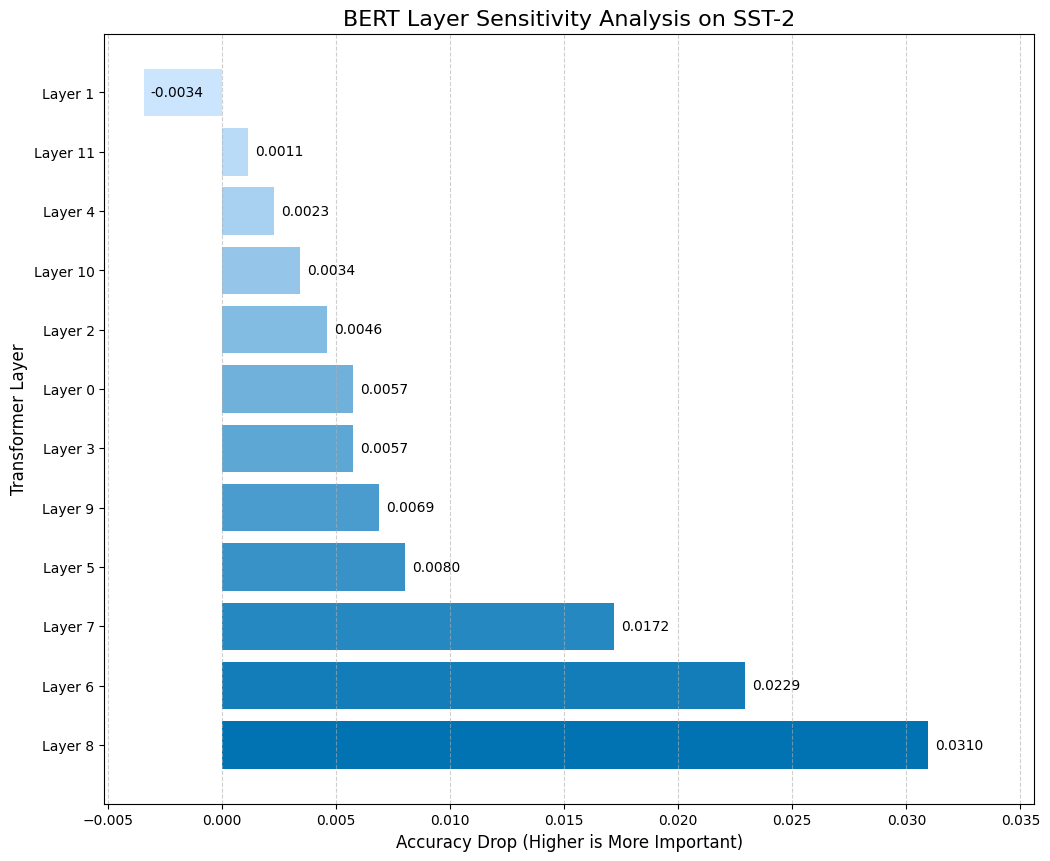

In [8]:
# =======================================================
# Cell 6: Analyze and Visualize Results
# =======================================================

# 1. 对结果按敏感度（值越小越不重要）进行排序
sorted_sensitivity = sorted(sensitivity_scores.items(), key=operator.itemgetter(1))

print("\n--- Layer Sensitivity Ranking (from least to most important) ---")
for layer_name, score in sorted_sensitivity:
    print(f"{layer_name}: {score:.4f}")

# 2. 准备数据进行可视化
layers = [item[0] for item in sorted_sensitivity]
scores = [item[1] for item in sorted_sensitivity]

# =======================================================
# 4. Define Gradient Color Scheme
# =======================================================
# Define start (light) and end (dark) colors for the gradient
start_color = np.array([204, 229, 255]) / 255 # Light Blue
end_color = np.array([1, 115, 178]) / 255     # #0173B2 Calm Blue (from our established palette)

# Generate a list of colors for each bar
num_bars = len(layers)
gradient_colors = [start_color + (end_color - start_color) * i / (num_bars - 1) for i in range(num_bars)]

# =======================================================
# 5. Create the Visualization with New Scheme
# =======================================================
plt.figure(figsize=(12, 10)) # Increased height for better readability

# Create horizontal bar chart with the new gradient colors
bars = plt.barh(layers, scores, color=gradient_colors)

# Set labels and title in English as requested
plt.xlabel('Accuracy Drop (Higher is More Important)', fontsize=12)
plt.ylabel('Transformer Layer', fontsize=12)
plt.title('BERT Layer Sensitivity Analysis on SST-2', fontsize=16)
plt.gca().invert_yaxis()  # Place least important layer at the top

# Add numerical labels to each bar
for bar in bars:
    plt.text(bar.get_width() + (max(scores) * 0.01), # Add slight offset for clarity
             bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}',
             va='center', ha='left')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(right=max(scores) * 1.15) # Adjust x-axis limit to fit text labels

# =======================================================
# 6. Apply New Saving Logic
# =======================================================
# Define output directory and filename
output_dir = 'figure'
output_filename = 'bert_layer_sensitivity_analysis.svg'

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save as a transparent, editable SVG file
plt.savefig(os.path.join(output_dir, output_filename), format='svg', bbox_inches='tight', transparent=True)
print(f"\nChart saved as an editable SVG file: {os.path.join(output_dir, output_filename)}")

plt.show()